# Importamos las librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time

from shutil import move
from random import sample
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from random import sample
import shutil
import keras.metrics
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras import optimizers
from keras.applications.vgg19 import VGG19
from tqdm.keras import TqdmCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
import math
from IPython.display import clear_output


### Obtenemos las carpetas de entrenamiento y validación

Ya habiendo descargado las carpetas que generamos en la notebook anterior, solamente las cargamos en esta notebook.

In [2]:
validation_dir = 'validation'
final_train = 'final_train'
classes = len(os.listdir(final_train))

Función para hacer el sobremuestreo. Adaptación del código proporcionado por el profesor Daniel Otero Fadul

In [3]:
def Crear_Imgs(target_number,train_dir,clase, max_imgs):

  temp_dir = os.path.join(train_dir, clase)

  img_names = [os.path.join(temp_dir, name) for name in os.listdir(temp_dir)]
  remainder = sample(img_names, k=target_number % len(img_names))   
  target_per_img = target_number // len(img_names) - 1
  i, j, k = 0, 0, 0

  for img_path in img_names:
      img = tf.keras.preprocessing.image.load_img(img_path)
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = img_array.reshape((1,) + img_array.shape)
      if len(os.listdir(temp_dir)) > max_imgs:
          break
      for batch in train_datagen.flow(img_array, batch_size=1):
          temp = tf.keras.preprocessing.image.array_to_img(batch[0])
          zeros = 9 - len(str(i + 1))
          name = zeros * '0' + str(i + 1)
          name = os.path.join(temp_dir, name + '.jpg')
          temp.save(name)
          i += 1
          if img_path in remainder:
              j += 1
              if j == (target_per_img + 1):
                  j = 0
                  break
          elif img_path not in remainder:
              k += 1
              if k == target_per_img:
                  k = 0
                  break
          if len(os.listdir(temp_dir)) > max_imgs:
              break
      if len(os.listdir(temp_dir)) > max_imgs:
          break            
                
              

In [4]:
final_train_len = [len(os.listdir(os.path.join(final_train, i)))for i in os.listdir(final_train)]
max_cant = 90
print(max_cant)
count = sum(map(lambda x : x < max_cant, final_train_len))
print("El " , round(count/len(final_train_len)*100,3), "% de las clases tienen menos de 90 imagenes")

90
El  0.0 % de las clases tienen menos de 90 imagenes


In [5]:
train_set = [i for i in os.listdir(final_train)]

Realizamos el sobremuestreo para todas las carpetas, además hacemos que el límite del sobremuestreo sea de 90 imagenes. Es decir, si una carpeta tiene menos de 90 imagenes, se hace el sobremuestreo hasta que tenga por lo menos 90 imagenes.

In [6]:
for idx,folder in enumerate(train_set):
    print(round(idx/len(train_set)*100,2) ,'% (', idx ,') de avance en la carpeta ' ,str(folder))
    while len(os.listdir(os.path.join(final_train,folder))) < max_cant:
        Crear_Imgs(2,final_train, folder, max_cant)
    clear_output(wait=False)


Selecionamos los datagens de el conjunto de entrenamiento y el de validación

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen= ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(final_train,
                                                target_size=(150, 150),
                                                batch_size=int(classes*0.35),
                                                class_mode='categorical',
                                                color_mode = 'rgb',
                                                shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    target_size=(150, 150),
                                                    batch_size=int(classes*0.35),
                                                    class_mode='categorical',
                                                    color_mode = 'rgb',
                                                    shuffle = True)

Found 21217 images belonging to 174 classes.
Found 1990 images belonging to 174 classes.


In [8]:
len(os.listdir(os.path.join(final_train,'27279')))

91

### Usando transfer learning, usamos la parte convolucional de la red VGG19 que es parte de Keras

Usamos transfer learning, importamos la arquitectura ya entrenada de una red convolucional que se encuentra dentro de Keras. Nos sirve que la red sea ya entrenada, puesto que en teoría se tarda menos en encontrar filtros que se adapten bien a nuestro conjunto de entrenamiento.

In [9]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

#### Seleccionamos las capas de esta red que queremos que se entrenen

Para obtener mejores resultados, hacemos que todas las capas convolucionales sean entrenables.

In [10]:
for idx, layer in enumerate(conv_base.layers): 
  #layer.trainable = False
  if idx in[1,2,4,5,7,8,9,10,12,13,14,15,17,18,19,20]:
    layer.trainable = True
    print(str(idx) +' Layer ' + layer.name + ' trainable')
  else:
    layer.trainable = False
    print(str(idx) + ' Layer ' + layer.name + ' not trainable')

0 Layer input_1 not trainable
1 Layer block1_conv1 trainable
2 Layer block1_conv2 trainable
3 Layer block1_pool not trainable
4 Layer block2_conv1 trainable
5 Layer block2_conv2 trainable
6 Layer block2_pool not trainable
7 Layer block3_conv1 trainable
8 Layer block3_conv2 trainable
9 Layer block3_conv3 trainable
10 Layer block3_conv4 trainable
11 Layer block3_pool not trainable
12 Layer block4_conv1 trainable
13 Layer block4_conv2 trainable
14 Layer block4_conv3 trainable
15 Layer block4_conv4 trainable
16 Layer block4_pool not trainable
17 Layer block5_conv1 trainable
18 Layer block5_conv2 trainable
19 Layer block5_conv3 trainable
20 Layer block5_conv4 trainable
21 Layer block5_pool not trainable


### Hacemos el modelo, con la base convolucional de la red VGG19, además de dos capas ocultas con 512 y 1024 neuronas, además de una última capa que indica la clase a la que pertenece una imagen.

In [11]:
model = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(512, activation='relu'),
                           Dense(1024, activation='relu'),
                           Dense(classes, activation='softmax')                    
                          ])

Como función de pérdida utilizamos 'categorical_crossentropy', la cual es buena para tareas de clasificación múltiple. El optimizador es el 'adam', el por defecto. Para la métrica utilizamos 'CategoricalAccuracy', la cual debería de ser de las mejores para sets de datos con muchas categorias.

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=tf.keras.metrics.CategoricalAccuracy())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 174)               178350    
                                                                 
Total params: 24,922,862
Trainable params: 24,922,862
Non-trainable params: 0
_________________________________________________________________


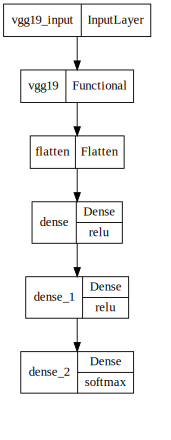

In [13]:
SVG(model_to_dot(model, dpi = 65, show_layer_activations=True, show_shapes=False).create(prog='dot', format='svg'))

### Realizamos el entrenamiento de nuestra red

Para el problema del desbalanceo de clases hacemos un diccionario que tiene asignados pesos a cada una de las clases. Este peso es $\frac{1}{\text{Cantidad de imagenes en la clase}}$. Esto en lo que nos ayudara es que dará mayor importancia a los errores con clases con menor cantidad de imagenes.

In [14]:
clases = os.listdir('final_train')
nums = [i for i in range(len(clases))]
peso_ind = [1/len(os.path.join(i, 'final_train' )) for i in clases]
pesos = dict(zip(nums, peso_ind))

In [15]:
start1 = time()
history = model.fit(train_generator, steps_per_epoch=10, epochs=15, class_weight= pesos ,validation_data=validation_generator, validation_steps=5, verbose=0, callbacks=[TqdmCallback(verbose=1)])
fin1 = time()-start1
print(f"El tiempo de entrenamiento fue de {math.floor(fin1/60):d} minutos y {int(fin1 % 60):d} segundos")

100%|██████████| 15/15 [56:25<00:00, 225.73s/epoch, loss=0.289, categorical_accuracy=0.0717, val_loss=4.69, val_categorical_accuracy=0.103] 

El tiempo de entrenamiento fue de 56 minutos y 28 segundos


#### Observamos los resultados obtenidos

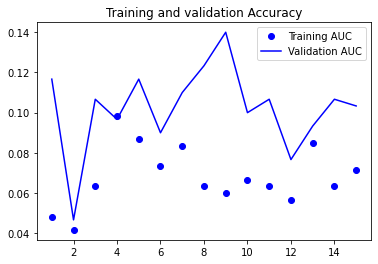

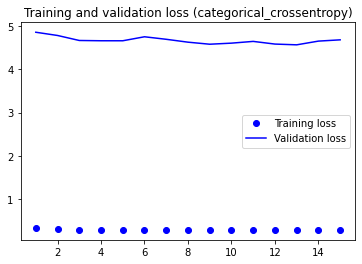

In [18]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (categorical_crossentropy)')
plt.legend()
plt.show()

In [17]:
model.save('modelo.h5')
#model = keras.models.load_model('modelo.h5')

Al final, arriba podemos observar los resultados obtenidos. Creemos que el validation_accuracy es mayor en el conjunto de validación debido a que en el conjunto de entrenamiento se realizo data augmentation, lo cual genera imagenes rotadas, movidas, con alguna traslación o reflejo, lo cual puede ayudar a entrenar el modelo, pero no ayuda mucho al momento de hacer la evaluación con el conjunto de entrenamiento. Además podemos observar que en el conjunto de validación, la función de pérdida va bajando, aunque la mejora no es muy notoría.